# Hidden Markov Model (HMM)

In [3]:
import numpy as np
import scipy as sp
import scipy.stats as st
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
import matplotlib as mpl
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['axes.titlesize'] = 18
mpl.rcParams['figure.figsize'] = (15, 5)

### Markov Model

* Random stochastic transitions between a set of discrete states, with each transition ocurring at an average rate.
* *Memoryless*: Next transition depends only on the current state, not the past history.

### Hidden Markov Model

* We don't observe the states directly, but instead we observe a probabilistic output (emission) from each state.
* Observations are random variables from probability distributions that may differ for each state.

![HMM](images/hmm.png)

The probability of getting a particular sequence of observations $O_1, O_2, ...$ is given by

### $\begin{align}
P(O_1, O_2, ...) &= \sum_{S_1, S_2, ...} P(S_1) P(S_1 \rightarrow O_1) P(S_1 \rightarrow S_2)  P(S_2 \rightarrow O_2) P(S_2 \rightarrow S_3)  P(S_3 \rightarrow O_3) ... \\
                 &= \sum_{S_1, S_2, ...} P(S_1) P(S_1 \rightarrow O_1) \prod_{i \geq 2} P(S_{i-1} \rightarrow S_i)  P(S_i \rightarrow O_i)
\end{align}$

---
# 3-State HMM for Ion Channel Gating

A simple model of ion channel gating with two nonconducting states ($Closed, Desensitized$) and one conducting state ($Open$).

### $Closed \rightleftarrows Open \rightleftarrows Desensitized$

---
## State Sequence

## <font color=blue>Learning Objectives:</font>
1. You will understand how to generate a state sequence from a starting probability vector `p0` and transition probability matrix `A`.

In [112]:
# transition probability matrix for each time step
# A[i,j] is transition probability from state i to state j
A = np.array([[0.92, 0.08, 0.00],     # P(C->C), P(C->O), P(C->D)
              [0.03, 0.95, 0.02],     # P(O->C), P(O->O), P(O->D)
              [0.00, 0.005, 0.995]])  # P(D->C), P(D->O), P(D->D)

# initial state probabilities (i.e. probability that we start off in each state)
# p0[i] is the probability of starting in state i
p0 = np.array([1, 0, 0])     # P(C), P(O), P(D)

# memory for state sequence of time points
state_seq = np.zeros(1000000, dtype=int)

states = [0, 1, 2]

# set initial state by drawing from initial state probability array
state_seq[0] = np.random.choice(states, p=p0)

# for each subsequent time point, set the state based on the transition probabilities out of the current state
for t in range(len(state_seq)-1):
    state = state_seq[t]
    state_seq[t+1] = np.random.choice(states, p=A[state,:])

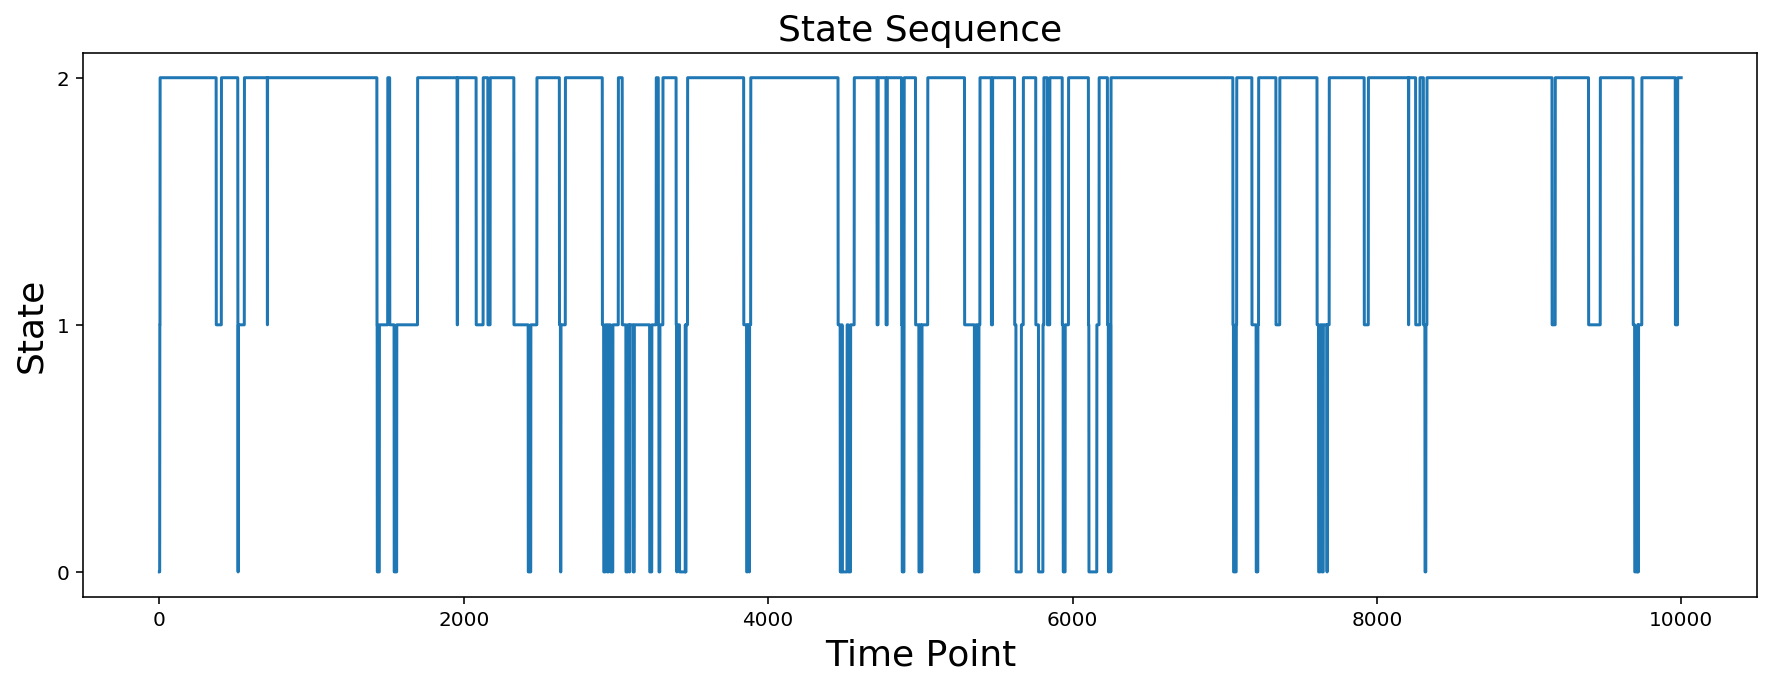

In [113]:
# plot the state sequence
N = 10000
plt.plot(state_seq[:N])
plt.yticks(states)
plt.xlabel('Time Point')
plt.ylabel('State')
plt.title('State Sequence');

---
## Hidden State Sequence ($C, O, D$) $\rightarrow$ Observed Channel Current

Assume current in each state is normally distributed.

## <font color=blue>Learning Objectives:</font>
1. You will understand how to generate a plausible ion channel current recording from an underlying hidden state sequence.

In [114]:
# emission probability distributions for each state
# state_emission_pds[i] is the emission probability distribution for state i
closed_pd = st.norm(0, 1)
open_pd = st.norm(5, 1.5)
desensitized_pd = st.norm(0, 1)

state_emission_pds = [closed_pd, open_pd, desensitized_pd]

# memory for observation sequence
observed_current = np.zeros(state_seq.shape)

# for each state in the sequence, generate an observed emission value
for state in states:
    indices = np.where(state_seq == state)[0]
    observed_current[indices] = state_emission_pds[state].rvs(len(indices))

# here's the brute force loop approach. It's horribly slow.
# for t in range(len(state_seq)):
#     state = state_seq[t]
#     observed_current[t] = state_emission_pds[state].rvs()

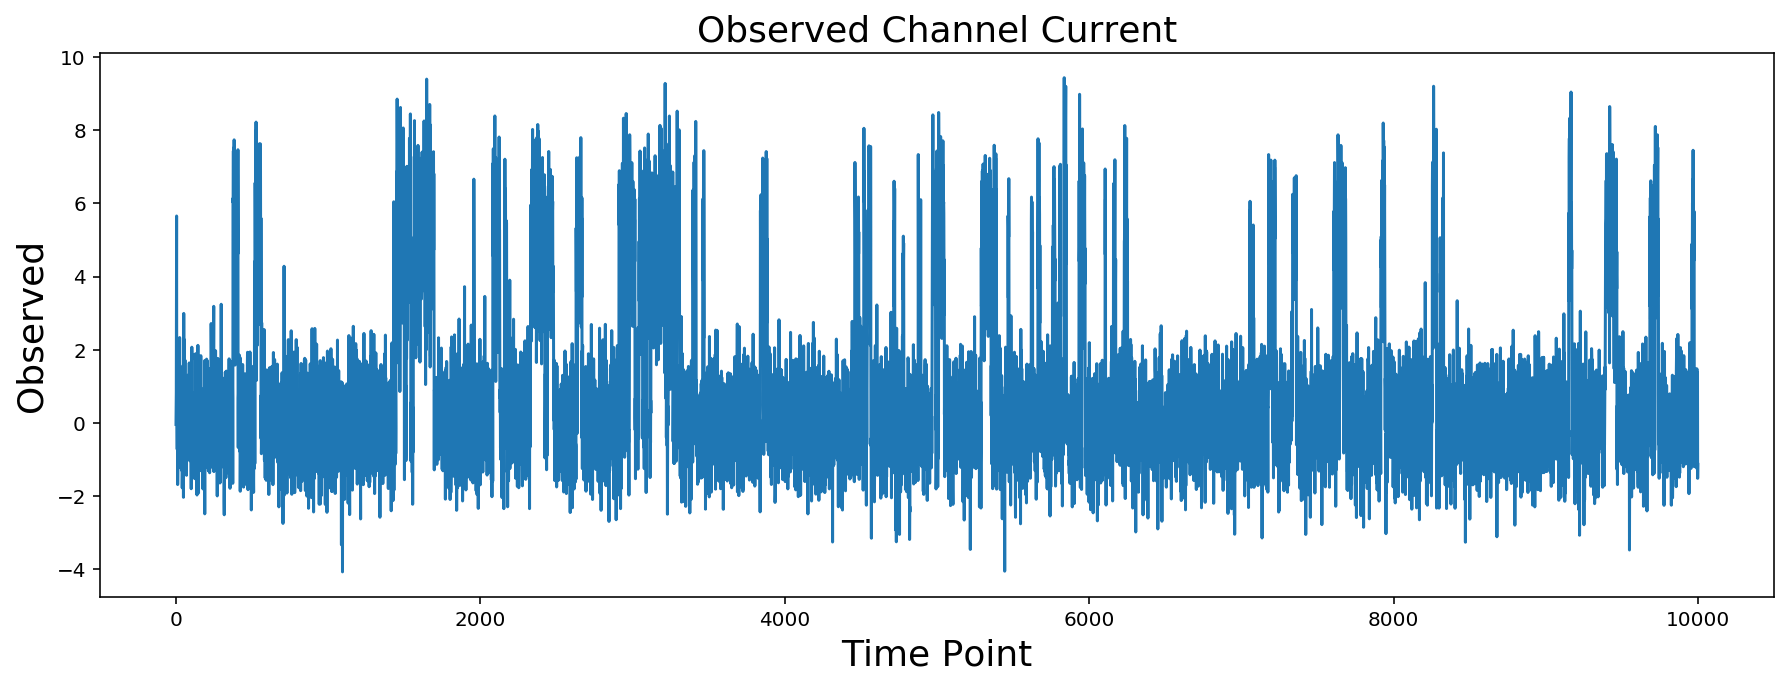

In [115]:
# plot the observed sequence
N = 10000
plt.plot(observed_current[:N])
plt.xlabel('Time Point')
plt.ylabel('Observed')
plt.title('Observed Channel Current');

## <font color=red>Exercises</font>

1. Why does it look like there are only two current levels?

---
## Cluster data points based on amplitude with a Gaussian Mixture Model (GMM)

## <font color=blue>Learning Objectives:</font>
1. More practice with GMMs.

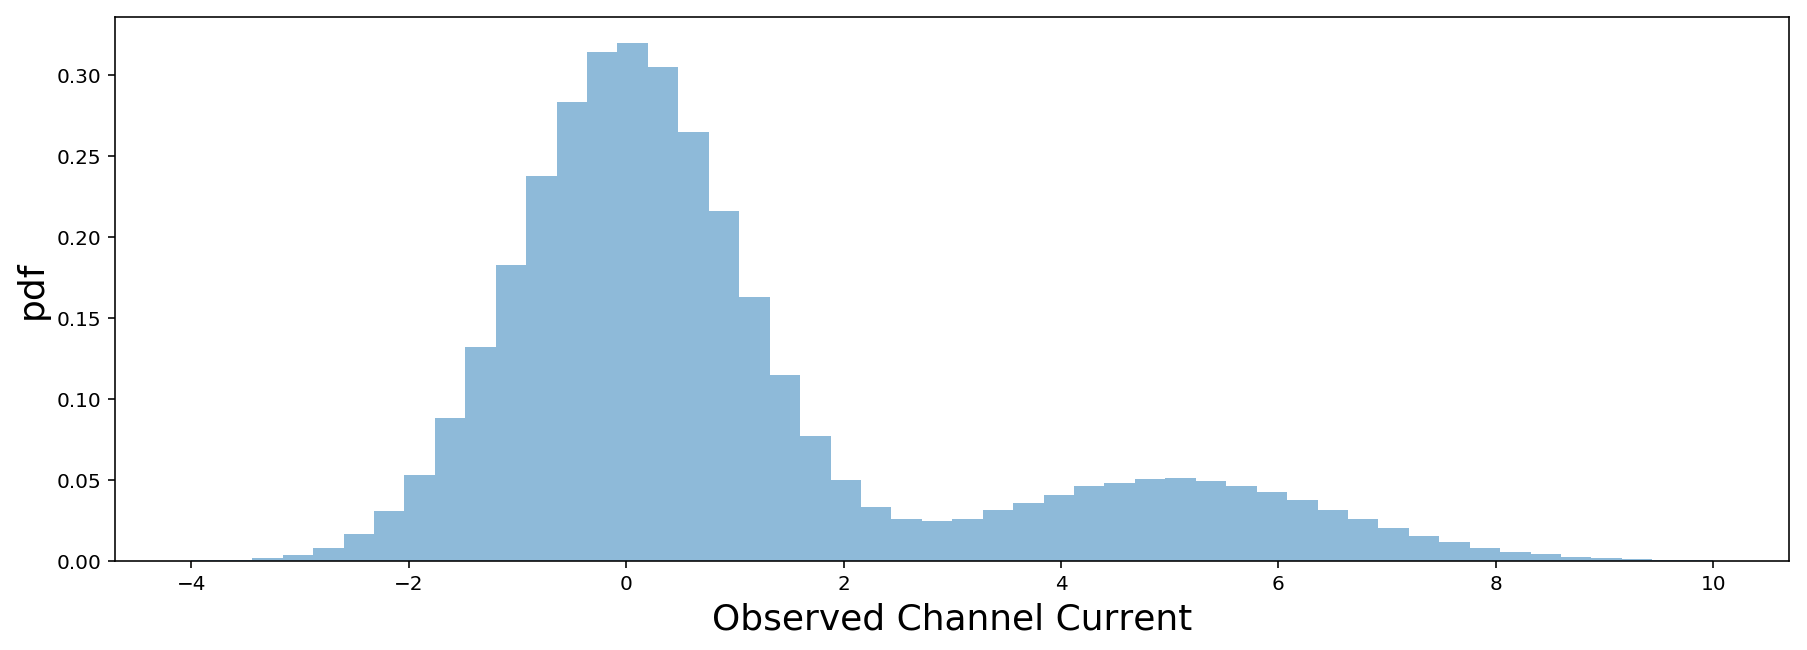

In [116]:
binEdges = np.linspace(-4, 10, 51)  # 51 edges -> 50 bins
plt.hist(observed_current, bins=binEdges, alpha=0.5, density=True)
plt.xlabel('Observed Channel Current')
plt.ylabel('pdf');

In [117]:
# conda install -c intel scikit-learn
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=2, random_state=1)
gmm.fit(observed_current.reshape(-1, 1))

gmm

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=2, n_init=1, precisions_init=None,
                random_state=1, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

In [118]:
gmm_predicted_state_seq = gmm.predict(observed_current.reshape(-1, 1))

print(gmm_predicted_state_seq[:99])

[0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


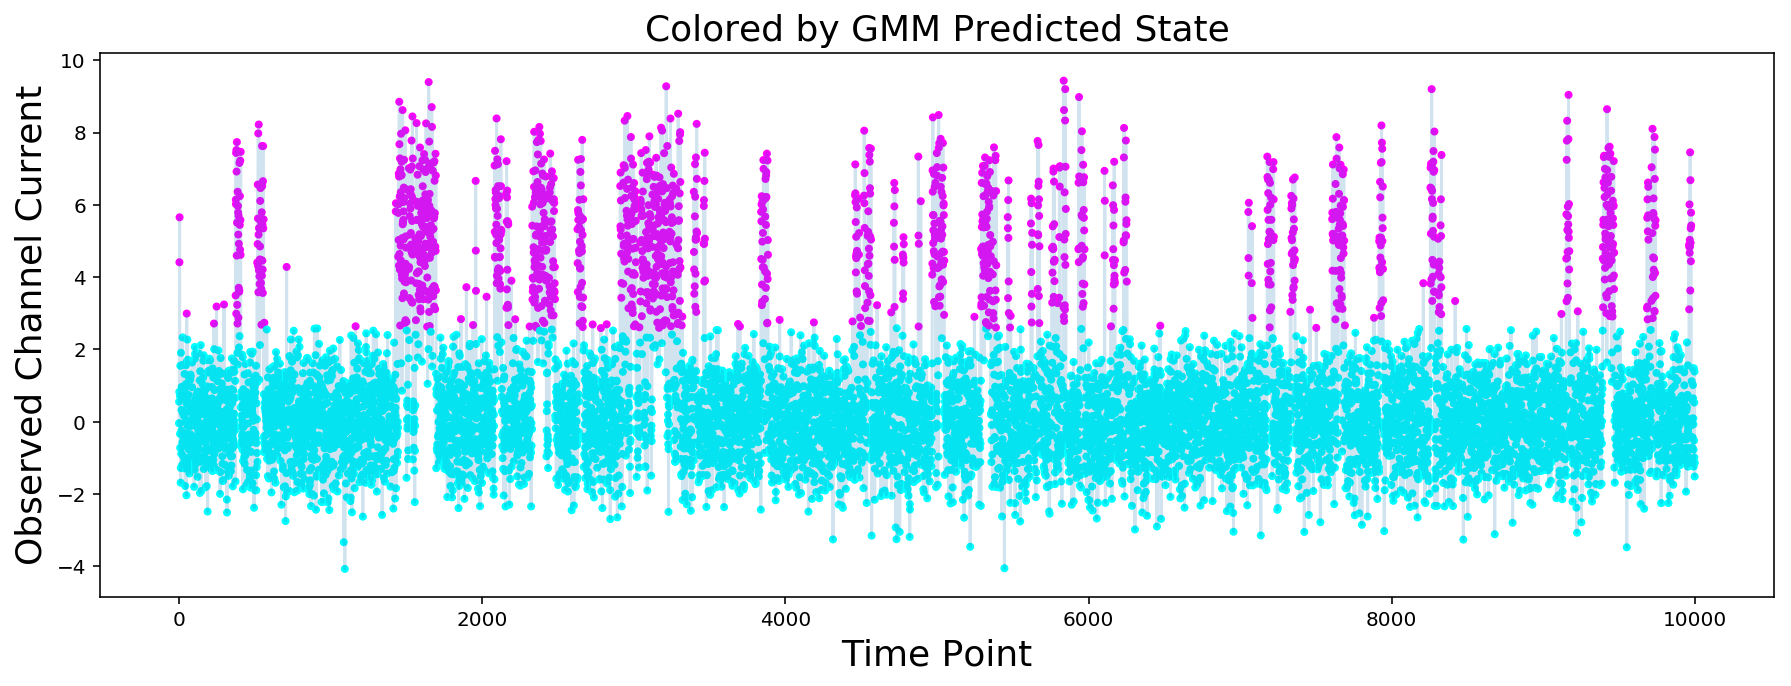

In [119]:
# plot the observed sequence
# with data points colored by their predicted state
N = 10000
plt.plot(observed_current[:N], alpha=0.2)
plt.scatter(range(N), observed_current[:N], marker='.', c=gmm_predicted_state_seq[:N], cmap='cool')
plt.xlabel('Time Point')
plt.ylabel('Observed Channel Current')
plt.title('Colored by GMM Predicted State');

# <font color=red>!!! But GMM only gave us 2 states, and we happen to know the model has 3 states!</font>

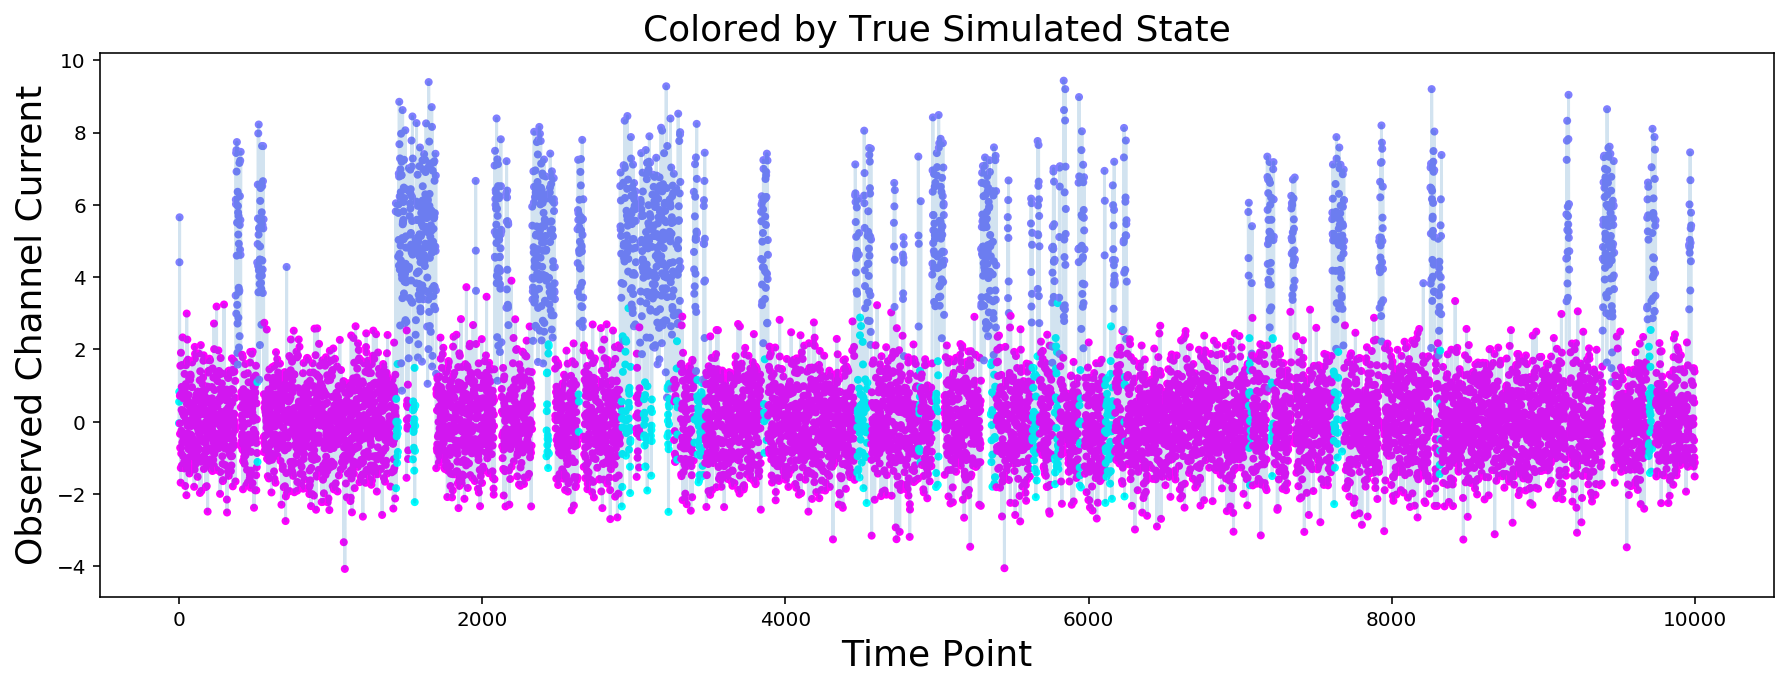

In [120]:
# plot the observed sequence
# with data points colored by their predicted state
N = 10000
plt.plot(observed_current[:N], alpha=0.2)
plt.scatter(range(N), observed_current[:N], marker='.', c=state_seq[:N], cmap='cool')
plt.xlabel('Time Point')
plt.ylabel('Observed Channel Current')
plt.title('Colored by True Simulated State');

## <font color=red>Exercises</font>

1. Whats different about the closed and desensitized states?

---
## Dwell Time Distributions

* The lifetimes of each closed (or desensitized) and open event as predicted from the observed channel current.
* We'll use the GMM prediction to segregate closed (or desensitized) vs open data points.

## <font color=blue>Learning Objectives:</font>
1. Become familiar with `np.diff`.
2. Compute closed and open lifetimes from the GMM predicted level sequence.

In [121]:
print(gmm_predicted_state_seq[:99])

diff_gmm_predicted_state_seq = np.diff(gmm_predicted_state_seq)

print(diff_gmm_predicted_state_seq[:99])

[0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 0  0  1  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0]


In [122]:
co_pts = np.where(diff_gmm_predicted_state_seq == 1)[0]
oc_pts = np.where(diff_gmm_predicted_state_seq == -1)[0]

co_pts[:9], oc_pts[:9]

(array([  2,  50, 230, 247, 296, 373, 385, 388, 396]),
 array([  4,  51, 231, 248, 297, 384, 387, 395, 399]))

In [123]:
N = min(len(co_pts), len(oc_pts))

start_state = gmm_predicted_state_seq[0]

if start_state == 0:
    # start closed
    closing_starts = oc_pts
    closing_ends = co_pts[1:]
    N = min(len(closing_starts), len(closing_ends))
    closed_lifetimes_pts = closing_ends[:N] - closing_starts[:N]
    
    opening_starts = co_pts
    opening_ends = oc_pts
    N = min(len(opening_starts), len(opening_ends))
    open_lifetimes_pts = opening_ends[:N] - opening_starts[:N]
else:
    # start open
    closing_starts = oc_pts
    closing_ends = co_pts
    N = min(len(closing_starts), len(closing_ends))
    closed_lifetimes_pts = closing_ends[:N] - closing_starts[:N]
    
    opening_starts = co_pts
    opening_ends = oc_pts[1:]
    N = min(len(opening_starts), len(opening_ends))
    open_lifetimes_pts = opening_ends[:N] - opening_starts[:N]

open_lifetimes_pts[:9], closed_lifetimes_pts[:9]

(array([ 2,  1,  1,  1,  1, 11,  2,  7,  3]),
 array([ 46, 179,  16,  48,  76,   1,   1,   1,   1]))

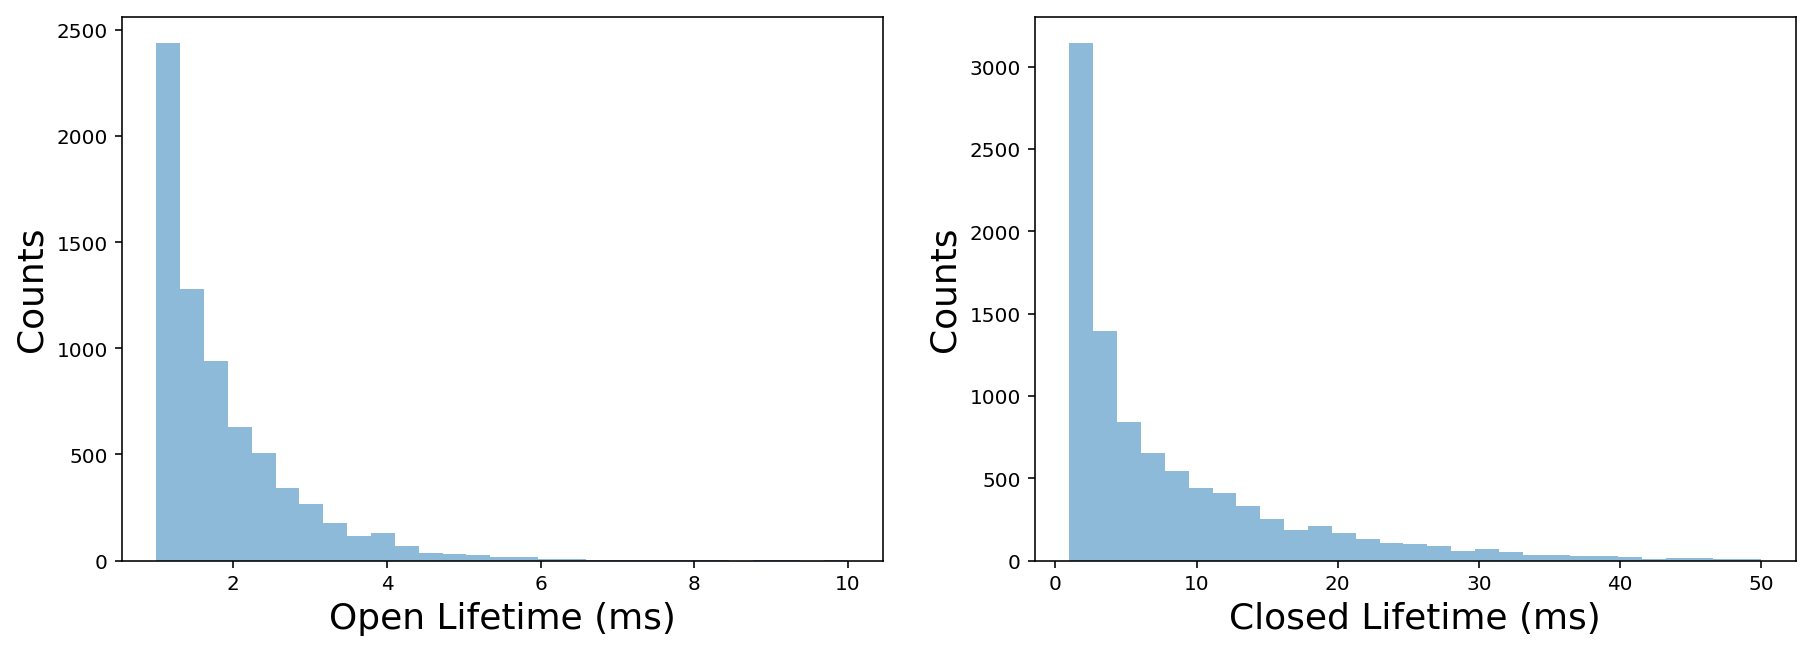

In [141]:
dt_ms = 0.1  # sample interval

# convert lifetimes from time steps to times
open_lifetimes_ms = open_lifetimes_pts * dt_ms
closed_lifetimes_ms = closed_lifetimes_pts * dt_ms

plt.subplot(121)
binedges = np.linspace(1, 10, 30)
plt.hist(open_lifetimes_ms, binedges, alpha=0.5)
plt.xlabel('Open Lifetime (ms)')
plt.ylabel('Counts')

plt.subplot(122)
binedges = np.linspace(1, 50, 30)
plt.hist(closed_lifetimes_ms, binedges, alpha=0.5)
plt.xlabel('Closed Lifetime (ms)')
plt.ylabel('Counts');

---
## Plotting Exponential Distributions on a logscale

* This is useful because on a logscale, an exponential distribution has a peak at its mean (tau).

### <font color=red>However, simply plotting the above lifteime distribution histograms on a logscale results in nonuniform bin widths.</font>

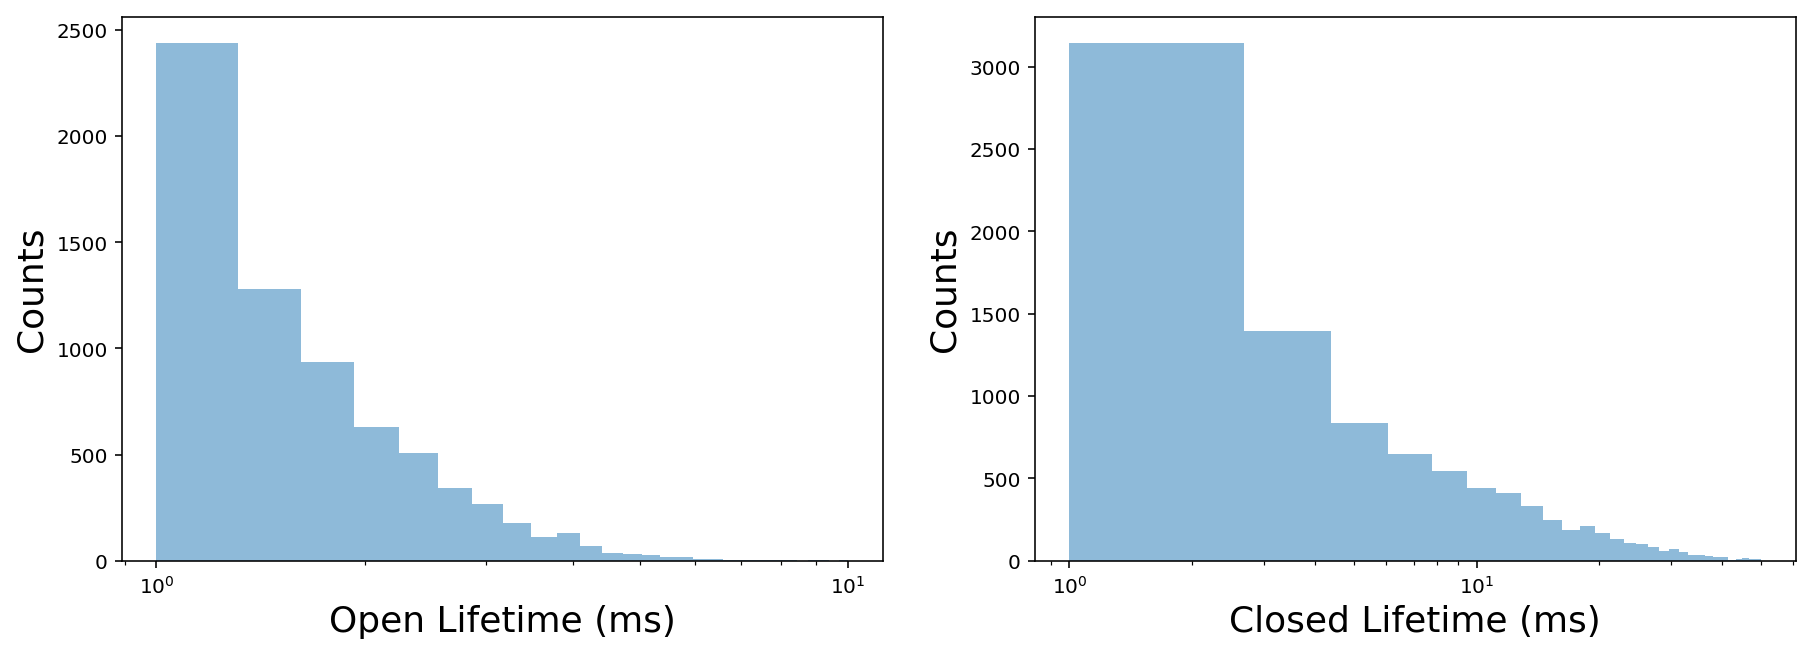

In [142]:
plt.subplot(121)
binedges = np.linspace(1, 10, 30)
plt.hist(open_lifetimes_ms, binedges, alpha=0.5)
plt.xlabel('Open Lifetime (ms)')
plt.ylabel('Counts')
plt.xscale('log')

plt.subplot(122)
binedges = np.linspace(1, 50, 30)
plt.hist(closed_lifetimes_ms, binedges, alpha=0.5)
plt.xlabel('Closed Lifetime (ms)')
plt.ylabel('Counts')
plt.xscale('log');

## Instead, we take the $log$ of the dwell times and then create a histogram from that with evenly spaced logscale bin widths.

* The advantage of this representation of the data is that exponential distributions have a peak on a log scale at their time constant, which can make resolving multiple components more visually obvious.

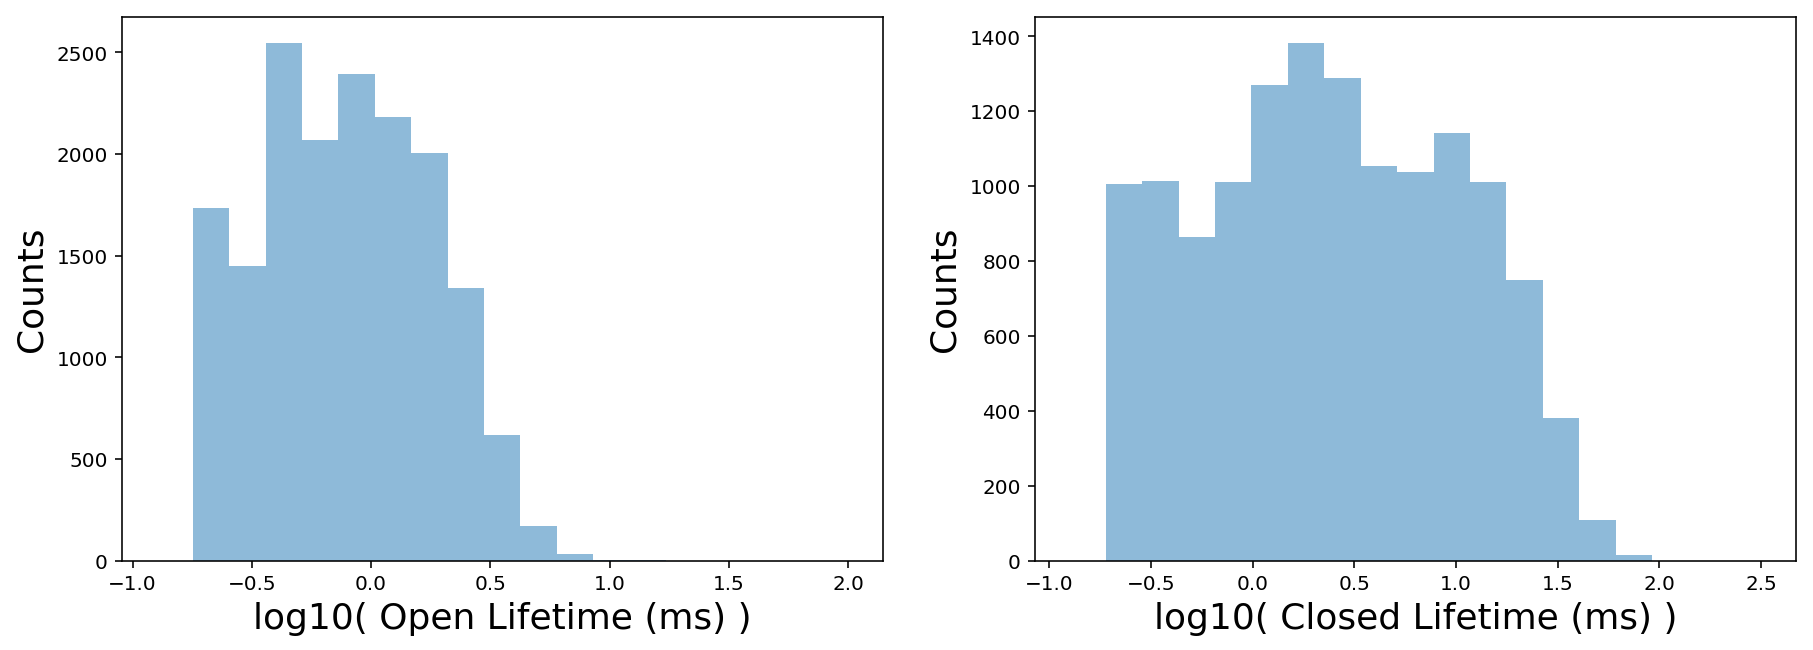

In [140]:
plt.subplot(121)
logbinedges = np.linspace(-0.9, 2, 20)
plt.hist(np.log10(open_lifetimes_ms), logbinedges, alpha=0.5)
plt.xlabel('log10( Open Lifetime (ms) )')
plt.ylabel('Counts')

plt.subplot(122)
logbinedges = np.linspace(-0.9, 2.5, 20)
plt.hist(np.log10(closed_lifetimes_ms), logbinedges, alpha=0.5)
plt.xlabel('log10( Closed Lifetime (ms) )')
plt.ylabel('Counts');

---
## Maximum likelihood exponential fitting of dwell time distributuions.

* Remember this?

## <font color=blue>Learning Objectives:</font>
1. Recall how to estimate parameters for an exponential distribution given some data.

## <font color=red>Exercises</font>

1. What is your best guess for the open time constant (tau)?

---
## The closed lifetimes have two obvious components (it's one for each closed state).

### To fit those we'll need to write a cost function and minimize the negative loglikelihood of a biexponential $PDF$ for the closed durations.

* Rememebr this?

## <font color=blue>Learning Objectives:</font>
1. Recall how to estimate parameters for a bi-exponential distribution given some data.

In [148]:
# fit closed durations to a biexponential distribution (i.e. weighted sum of two exponential distributions)
import scipy.optimize as opt

def biexp_pdf(times, params):
    A1, tau1, tau2 = params
    # This is just a weighted sum of two exponential PDFs.
    # The weights need to sum to one so that the combined probability of the two distributions is still one.
    return A1 * st.expon.pdf(times, 0, tau1) + (1 - A1) * st.expon.pdf(times, 0, tau2)

def closed_lifetimes_biexp_negLL(params):
    pdf = biexp_pdf(closed_lifetimes_ms, params)
    return -np.log(pdf).sum()

# A1, tau1 (ms), tau2 (ms)
params = [0.5, 1, 30]
bnds = opt.Bounds([0, 0.01, 1], [1, 10, 50])  # lower bounds, upper bounds
result = opt.minimize(closed_lifetimes_biexp_negLL, params, method='slsqp', bounds=bnds)
print(result)

     fun: 35981.8762770506
     jac: array([-0.09814453,  0.13378906,  0.        ])
 message: 'Optimization terminated successfully.'
    nfev: 90
     nit: 16
    njev: 16
  status: 0
 success: True
       x: array([0.51884156, 0.18593241, 7.40960109])


In [149]:
# parameters for closed durations fit
A1, tau1, tau2 = result.x
A2 = 1 - A1

print(f'{tau1:.1f} ms ({(A1 * 100):.1f} %)')
print(f'{tau2:.1f} ms ({(A2 * 100):.1f} %)')

0.2 ms (51.9 %)
7.4 ms (48.1 %)


In [151]:
np.log10(tau1), np.log10(tau2)

(-0.7306449098084667, 0.8697948277187937)